# Test Boundaries

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from skimage.measure import regionprops
from scipy.ndimage import label, median_filter, find_objects
from sklearn.mixture import GaussianMixture
from scipy.optimize import curve_fit
from math import pi

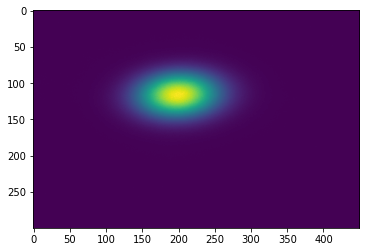

In [2]:
# create roi
with open('D:\\HZB\\Camera_Data\\mls13\\1test.npy', 'rb') as f:
        data = np.load(f)
data = data.reshape(1456, 1936)
roi = data[(slice(600, 900, None),
            slice(800, 1250, None))]
plt.imshow(roi, cmap='viridis')
plt.show()

In [3]:
def guess( x, y, z):
        # guess the approximate values for the first fit analysis
        try:
            maxx, minx = np.amax(x), np.amin(x)
            maxy, miny = np.amax(y), np.amin(y)
            maxz, minz = np.amax(z), np.amin(z)

            centerx = x[np.argmax(z)]
            centery = y[np.argmax(z)]
            amplitude = (maxz - minz)  # more or less height

            sigmax = (maxx - minx) / 6.0 # works if frame is close around object
            sigmay = (maxy - miny) / 6.0 # works if frame is close around object
            offset = minz

            return amplitude, centerx, centery, sigmax, sigmay, 0, offset
        except:
            print('guessing initial fit params failed')
            return 0, 0, 0, 0, 0, 0, 0

def gaussian_model( x_y, amplitude, x_center, y_center, sigma_x, sigma_y, theta, offset):
        # calculate test data during fit algorithm to compare with data in
        x, y = x_y
        xo = float(x_center)
        yo = float(y_center)
        a = (np.cos(theta) ** 2) / (2 * sigma_x ** 2) + (np.sin(theta) ** 2) / (2 * sigma_y ** 2)
        b = -(np.sin(2 * theta)) / (4 * sigma_x ** 2) + (np.sin(2 * theta)) / (4 * sigma_y ** 2)
        c = (np.sin(theta) ** 2) / (2 * sigma_x ** 2) + (np.cos(theta) ** 2) / (2 * sigma_y ** 2)
        result = offset + amplitude * np.exp(
            - (a * ((x - xo) ** 2) + 2 * b * (x - xo) * (y - yo) + c * ((y - yo) ** 2)))
        return result.ravel()

edge_x = roi.shape[1]
edge_y = roi.shape[0]
    # TO DO: double check if there is some better syntax
x_values = np.repeat(np.array([range(0, edge_x)]), edge_y, axis=0).flatten()
y_list = []
for i in range(0, edge_y):
    y_list.append([i] * edge_x)
y_values = np.array(y_list).flatten()

# first fit analysis with founded guess and boundaries
z_values_in = roi.flatten()


initial_params = guess(x_values, y_values, z_values_in)
print(initial_params)
bounds = ([0, 0, 0, 0, 0, -pi / 4, 0], [16382, np.inf, np.inf, np.inf, np.inf, pi / 4, 16382])


popt, pcov = curve_fit(gaussian_model, (x_values, y_values), z_values_in, p0=initial_params, bounds=bounds)

(15258, 196, 115, 74.83333333333333, 49.833333333333336, 0, 115)


In [4]:
print(popt)

[1.52212944e+04 1.99233540e+02 1.16067220e+02 3.80977012e+01
 2.06015714e+01 4.61376850e-02 1.52729734e+02]


In [5]:
%timeit popt_1, pcov = curve_fit(gaussian_model, (x_values, y_values), z_values_in, p0=popt, bounds=bounds)

370 ms ± 72.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
%timeit popt_2, pcov = curve_fit(gaussian_model, (x_values, y_values), z_values_in, p0=popt)

149 ms ± 34.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
